## Časovne vrste

Modeliranje časovnih vrst je pomeben del ekonomskih modelov, borznega posredništva, analize časovnih meritev v fiziki, biologiji, kemiji, ipd.


Podatki v obliki časovnih vrst se od dosedanjih scenarijev razlikujejo po pomebni lastnosti: vzorci <i>niso</i> neodvisni med seboj. Podatke predstavlja vektor časovnih točk (ki niso nujno enako oddaljene):

$$ \mathbf{t} = (t_1, t_2, ..., t_n) $$

Običajno nas zanima <i>funkcija</i> oz. <i>signal</i> v vsaki časovni točki.

$$ x(\mathbf{t}) = (x(t_1), x(t_2), ..., x(t_n)) $$ 

In [1]:
import os
import sys
from dtw import *

%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
import matplotlib
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")

import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')
import matplotlib.cm as cm
import numpy as np
import scipy
import os
import GPy

np.random.seed(42)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Primerjava časovnih vrst

Oglejmo si preprost primer dveh podobnih signalov $x(\mathbf{t})$ in $y(\mathbf{t})$.

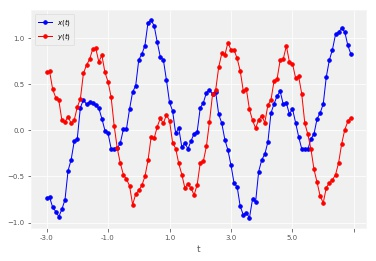

In [2]:
resolution = 100
t = np.linspace(-5, 5, resolution)
x = np.sin(t)    * np.cos(2*t) + 0.2*np.random.rand(1, resolution).ravel()
y = -np.sin(t-2) * np.cos(2*t + 4) + 0.2*np.random.rand(1, resolution).ravel()

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(t.reshape((len(t), 1)), x)
z = model.predict(t.reshape((len(t), 1)))

plt.figure()
plt.plot(x, "b.-", label="$x(t)$")
# plt.plot(z, "r-", label="$x(t)$")
plt.plot(y, "r.-", label="$y(t)$")
plt.gca().set_xticklabels(np.linspace(-5, 5, 6))
plt.xlabel("t")
plt.legend()
plt.show()

Opazimo, da sta si signala zelo podobna, vendar so vrhovi zelo oddaljeni med seboj. Kako izmeriti to razdaljo (npr. za potrebe hierarhičnega gručenja)? Evklidska razdalja vrne navidez zelo visoko vrednost.

In [3]:
np.linalg.norm(x[:-2]-x[2:], ord=2)

2.3668481204957907

Korelacija med signaloma je nizka oz. celo obratna.

In [4]:
scipy.stats.pearsonr(x, y)[0]

-0.2935973021857667

### Dinamična poravnava signalov



V splošnem imamo dva različno dolga signala:

$$ x(\mathbf{t}) = (x(t_1), x(t_2), ..., x(t_n)) $$ 
$$ y(\mathbf{t}) = (y(t_1), y(t_2), ..., y(t_m)) $$ 

Dinamična poravnava signalov (ang. <i>Dynamic time warping</i>, DTW) je algoritem dinamičnega programiranja, ki poišče signala $x_w(\mathbf{t})$ in $y_w(\mathbf{t})$, tako, da je razdalja med vrednostmi signalov $|x_w(t_k) - y_w(t_k)|$ čim manjša. Dovoljeno je lokalno raztezanje in krčenje obeh signalov.

Algoritem DTW sestavi matriko $\mathbf{W}$ velikosti $m \times n$ ki hrani razdalje, tako da 

$$w_{ij} = |x(t_i) - y(t_j)|$$

Cilj algoritma DTW je iskanje <b>poti</b> dolžine $max(m, n)$, ki gre iz levega spodnjega v desni zgornji kot matrike $\mathbf{W}$, tako da zmanjšamo skupno razdaljo

$$ \text{min} \sum_{k} \sqrt{w_k} $$

    

Rezultat algoritma je matrika poravnave, optimalna pot in skupna razdalja med signaloma.

In [5]:
alignment = dtw(x, y, keep_internals=True)

cost = alignment.costMatrix

print("Oddaljenost med x in y", alignment.distance)

Oddaljenost med x in y 45.37434846400915


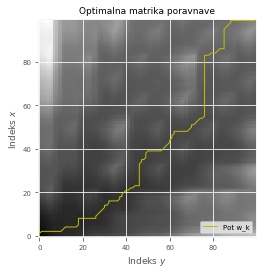

In [6]:
fig = plt.figure(2)
ax = fig.add_subplot(111)
plot1 = plt.imshow(cost.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot2 = plt.plot(alignment.index1, alignment.index2, 'y', label="Pot w_k")
xlim = ax.set_xlim((-0.5, cost.shape[0]-0.5))
ylim = ax.set_ylim((-0.5, cost.shape[1]-0.5))
plt.xlabel("Indeks $y$")
plt.ylabel("Indeks $x$")
plt.title("Optimalna matrika poravnave",)
plt.legend( loc=4)
plt.show()

Poravnana signala dobimo s poravnavo vrednosti na ustreznih mestih v zaporedju.

In [7]:
xw = x[alignment.index1]
yw = y[alignment.index2]

Korelacija med signaloma je bistveno večja!

In [8]:
scipy.stats.pearsonr(xw, yw)[0]

0.6203711616557267

Oba signala sta lokalno deformirana.

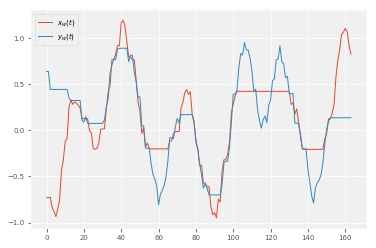

In [9]:
plt.figure()
plt.plot(xw, label="$x_w(t)$")
plt.plot(yw, label="$y_w(t)$")
plt.legend()
plt.show()

<font color="green"><b>Naredi sam/a.</b></font> Poišči slovenske občine s podobnimi trendi spreminjanja gostote prebivalstva. Oglej si trende nekaj najpodobnejših krajev.

In [10]:
x = np.loadtxt('podatki/ages/Maribor_starost-20-24_let.txt')
y = np.loadtxt('podatki/ages/Ljubljana_starost-20-24_let.txt')

In [11]:
# ... load all cities and store them into a matrix
import glob
labels = []
X = []

for f in glob.glob('podatki/ages/*_starost-20-24_let.txt'):
    city = os.path.basename(f).split("_")[0]
    labels.append(city)
    data = np.loadtxt(f)
    d = scipy.stats.zscore(data)
    X.append(d)
X = np.array(X)
X.shape

(59, 32)

<font color="green"><b>Namig.</b></font> Uporabi hierarhično razvšanje, kjer
namesto funkcije za razdaljo (`sch.linkage(metric=...)`) podaš razdaljo izmerjeno po DTW. 

In [12]:
import scipy.cluster.hierarchy as sch
# TODO: your code here